In [1]:
import osmnx
import geopandas

In [2]:
query = "Jericho, Oxford, UK"
lat, lon = osmnx.geocoder.geocode(query)
G = osmnx.graph.graph_from_point((lat, lon), 500, network_type="walk", retain_all=True)
nodes, edges = osmnx.convert.graph_to_gdfs(G)
display(edges.head(1))
display(nodes.head(1))

,,,osmid,highway,maxspeed,name,oneway,reversed,length,lanes,ref,geometry,width,service,est_width,bridge,tunnel,access
u,v,key,,,,,,,,,,,,,,,,
213881,346138799,0,3099324,residential,20 mph,Observatory Street,False,False,8.11893,NaN,NaN,"LINESTRING (-1.26295 51.76213, -1.26306 51.7621)",NaN,NaN,NaN,NaN,NaN,NaN


,y,x,street_count,highway,geometry
osmid,,,,,
213881,51.762131,-1.262952,3,NaN,POINT (-1.26295 51.76213)


In [3]:
edges.to_file("edges.geojson")
nodes.to_file("nodes.geojson")

In [4]:
tags = {"amenity": True}
amenities = osmnx.features.features_from_point((lat, lon), tags, 500)
amenities.amenity.value_counts().head(10)

amenity
bicycle_parking     74
parking             44
bench               19
restaurant          18
university          17
waste_basket        13
cafe                12
place_of_worship    10
pub                  9
library              8
Name: count, dtype: int64

In [5]:
amenities_gb = amenities.to_crs(27700)

In [6]:
cafes = amenities_gb.query(f'amenity=="cafe"')[["amenity", "geometry"]]
bicycle_parking = amenities_gb.query(f'amenity=="bicycle_parking"')[["amenity", "geometry"]]

In [7]:
cafes.geometry = cafes.geometry.centroid
cafe_buffer = cafes.copy()
cafe_buffer.geometry = cafes.geometry.buffer(100)

In [8]:
cafe_bicycle_parking = geopandas.sjoin(cafe_buffer, bicycle_parking, how="left", predicate="intersects") \
.groupby("id_left") \
.agg({"id_right": "count"}) \
.rename(columns={ "id_right": "bicyle_parking_areas_within_100m"}) \
.sort_values(by="bicyle_parking_areas_within_100m", ascending=False)
cafe_bicycle_parking

,bicyle_parking_areas_within_100m
id_left,
10711632158,15
3236075278,9
12050789742,9
111834945,6
3613566693,6
5006702146,6
113720932,3
662951456,3
111835073,2


<Axes: >

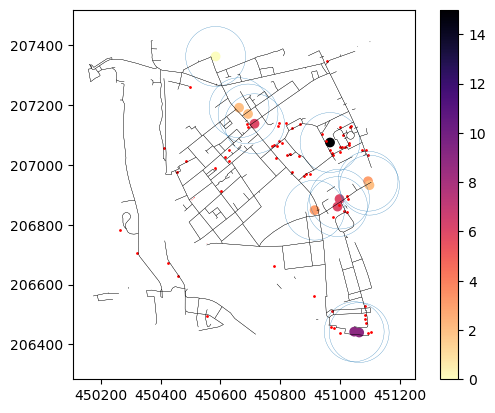

In [9]:
cafe_bicycle_parking.index.name = "id"
cafes_with_parking = cafes.join(cafe_bicycle_parking)
ax = cafes_with_parking.plot(column="bicyle_parking_areas_within_100m", legend=True, cmap="magma_r")

cafe_buffer.boundary.plot(ax=ax, linewidth=0.2)
bicycle_parking.plot(ax=ax, color="red", markersize=1)
roads = edges.to_crs(27700)
roads.plot(ax=ax, color='black', linewidth=0.2)
ax